Let's load up our data and take a look at our class imbalance.

In [1]:
import pandas as pd

COLUMNS = ['x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3',
       'y3', 'z3', 'x4', 'y4', 'z4', 'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7',
       'y7', 'z7', 'x8', 'y8', 'z8', 'x9', 'y9', 'z9', 'x10', 'y10', 'z10',
       'x11', 'y11', 'z11', 'x12', 'y12', 'z12', 'x13', 'y13', 'z13', 'x14',
       'y14', 'z14', 'x15', 'y15', 'z15', 'x16', 'y16', 'z16', 'x17', 'y17',
       'z17', 'x18', 'y18', 'z18', 'x19', 'y19', 'z19', 'x20', 'y20', 'z20']
DATA = '/kaggle/input/arabic-sign-language-letters-dataset/Arabic Sign Language Letters Dataset.csv'

df = pd.read_csv(filepath_or_buffer=DATA)
df['letter'].value_counts().to_frame().T

letter,Teh,Sheen,Beh,Theh,Al,Seen,Yeh,Sad,Alef,Dad,...,Reh,Heh,Waw,Tah,Khah,Qaf,Jeem,Zain,thal,Hah
count,278,274,274,271,269,262,261,261,258,256,...,206,203,201,196,196,193,192,191,188,188


Our classes are somewhat imbalanced, and we don't have a lot of data. This suggests this may not be an easy problem.

Let's use TSNE to add x/y coordinates based on our keypoints.

In [2]:
from sklearn.manifold import TSNE

reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
df[['x', 'y']] = reducer.fit_transform(X=df[COLUMNS])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7137 samples in 0.004s...
[t-SNE] Computed neighbors for 7137 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7137
[t-SNE] Computed conditional probabilities for sample 2000 / 7137
[t-SNE] Computed conditional probabilities for sample 3000 / 7137
[t-SNE] Computed conditional probabilities for sample 4000 / 7137
[t-SNE] Computed conditional probabilities for sample 5000 / 7137
[t-SNE] Computed conditional probabilities for sample 6000 / 7137
[t-SNE] Computed conditional probabilities for sample 7000 / 7137
[t-SNE] Computed conditional probabilities for sample 7137 / 7137
[t-SNE] Mean sigma: 0.223843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.141426
[t-SNE] KL divergence after 1000 iterations: 1.467814


Now let's use a scatter plot to take a look at our data.

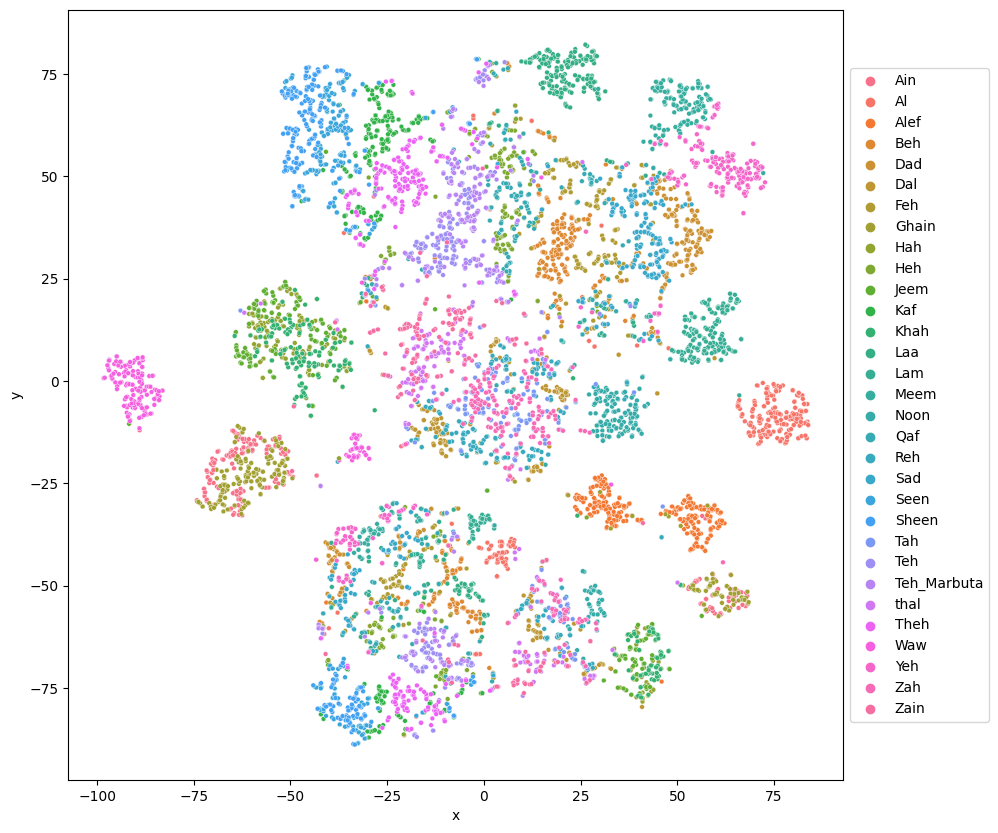

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='letter', s=12, ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

What do we see? We have a few characters that are in tight, isolated clusters, but by and large our characters are easily confused in twos and threes. Let's build a model and see what we get.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df['letter'], test_size=0.25, random_state=2025, stratify=df['letter'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 253 iterations
accuracy: 0.7927
f1: 0.7916
              precision    recall  f1-score   support

         Ain       0.98      0.92      0.95        52
          Al       0.83      0.73      0.78        67
        Alef       0.84      0.95      0.89        65
         Beh       0.59      0.67      0.63        69
         Dad       0.78      0.66      0.71        64
         Dal       0.63      0.78      0.70        55
         Feh       0.88      0.85      0.86        59
       Ghain       0.88      0.85      0.87        54
         Hah       0.76      0.66      0.70        47
         Heh       0.79      0.98      0.88        51
        Jeem       0.78      0.81      0.80        48
         Kaf       0.86      0.79      0.83        63
        Khah       0.88      0.88      0.88        49
         Laa       0.98      0.98      0.98        60
         Lam       0.62      0.62      0.62        63
        Meem       0.74      0.77      0.75        60
        Noon       0.84  

Honestly an f1 of nearly 0.8 isn't bad given what we have to work with. What do our model probabilities look like?

<Axes: xlabel='probability', ylabel='Count'>

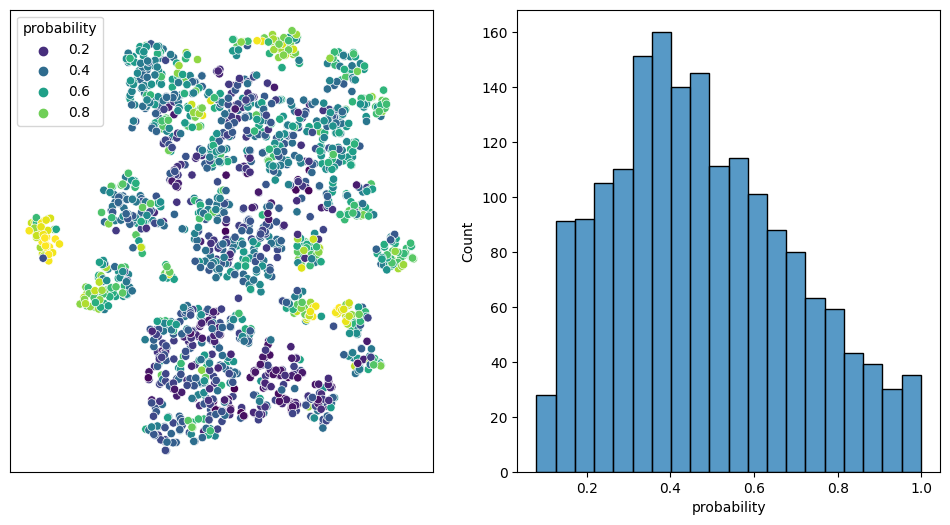

In [5]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot
import numpy as np

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

With rare exceptions our model probabilities are middling; this is not surprising given what we saw in the TSNE plot above. This is a tough problem, and an f1 of nearly 0.8 is pretty good.